# max entropy prior using normalizing-flow
In `nb/max_entropy_prior_correction.ipynb`, we were able to use the maximum entropy priors to impose uniform priors on $P({\rm SSFR}_{1Gyr})$ and $P({\rm SSFR}_{100Myr})$ individually. However, when we tried to impose uniform priors on the joint distribution $P({\rm SSFR}_{1Gyr}, {\rm SSFR}_{100Myr})$ we struggled. I suspect this is due to limitations of the KDE and GMM fits

In [4]:
!pip install corner
!pip install wquantiles

  Created wheel for wquantiles: filename=wquantiles-0.5-cp36-none-any.whl size=2509 sha256=29de3a7043356c2e4180c93b5cfeb313d27c0d7db33103a570a6d187f7b898a0
  Stored in directory: /root/.cache/pip/wheels/24/61/20/f9e1b00d1697d793c1b423cecbdb40fc65dd29a6188e78af41
Successfully built wquantiles


In [1]:
import os, h5py
import numpy as np 
import corner as DFM 
from time import time
import wquantiles as wq
from scipy.stats import gaussian_kde as gkde
from sklearn.mixture import GaussianMixture as GMix

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
tf.random.set_seed(1)

TFP Version 0.11.0
TF  Version 2.3.0


In [3]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
# read in 1 Gyr SSFR and 100 Myr SSFR
_ssfr_1gyr = np.load('_ssfr_1gyr.npy')
_ssfr_100myr = np.load('_ssfr_100myr.npy')

In [5]:
n_sample = 50000

ssfr_1gyr = _ssfr_1gyr[:n_sample]
ssfr_100myr = _ssfr_100myr[:n_sample]

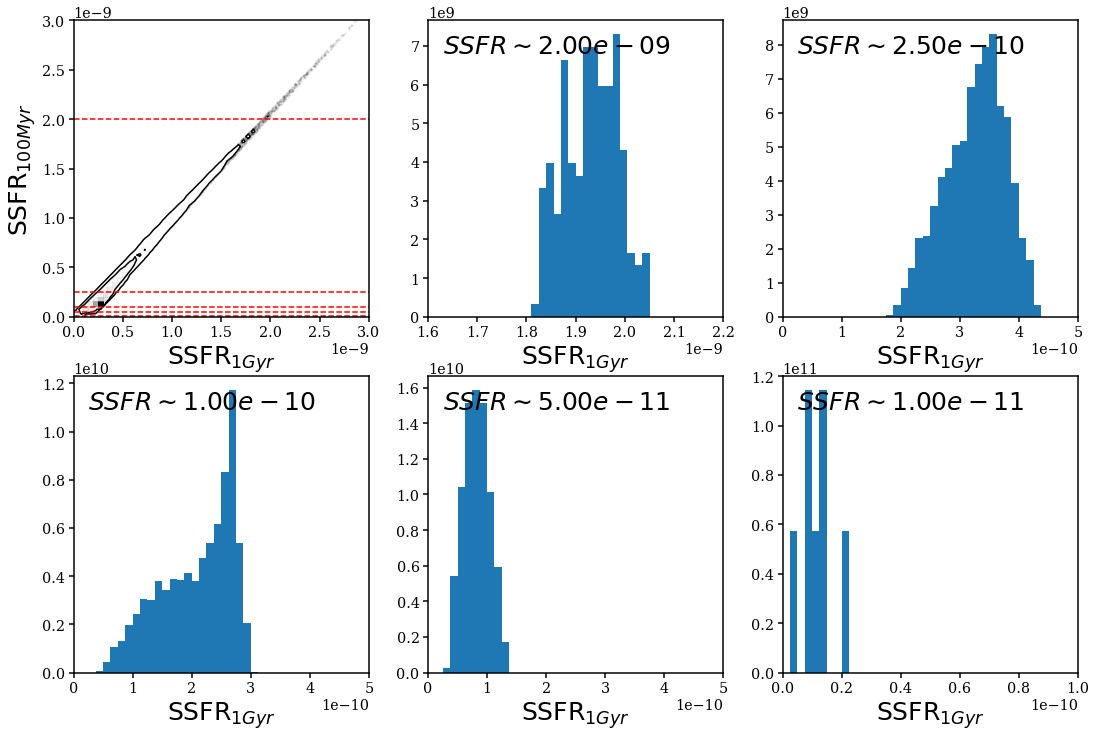

In [6]:
slices = [2e-9, 2.5e-10, 1e-10, 5e-11, 1e-11]
dslices = [1e-10, 5e-11, 5e-11, 1e-11, 5e-12]
ranges = [(1.6e-9, 2.2e-9), (0., 5e-10), (0., 5e-10), (0., 5e-10), (0., 1e-10)]

fig = plt.figure(figsize=(18,12))

sub = fig.add_subplot(231)

DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='k', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60,  
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 
for slice in slices: 
  sub.plot([0., 3e-9], [slice, slice], c='r', ls='--')

sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)
sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(0, 3e-9)

for i, slice, dslice, _range in zip(range(len(slices)), slices, dslices, ranges): 
  sub = fig.add_subplot(2,3,i+2)
  sub.hist(ssfr_1gyr[(ssfr_100myr > slice - dslice) & (ssfr_100myr < slice + dslice)], range=_range, bins=40, density=True)
  sub.text(0.05, 0.95, r'$SSFR \sim %.2e$' % slice, 
          transform=sub.transAxes, ha='left', va='top', fontsize=25)
  sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
  sub.set_xlim(_range)

In [7]:
def bestfit_gmm(x, max_comp=5): 
    # fit GMMs with a range of components 
    ncomps = range(1, max_comp+1)
    gmms, bics = [], []  
    for i_n, n in enumerate(ncomps): 
        gmm = GMix(n_components=n)
        gmm.fit(x)
        bics.append(gmm.bic(x)) # bayesian information criteria
        gmms.append(gmm)

    # components with the lowest BIC (preferred)
    i_best = np.array(bics).argmin()
    print(ncomps[i_best]) # number of components of the best-fit
    gbest = gmms[i_best] # best fit GMM 
    return gbest

In [8]:
kde_ssfr1gyr100myr = gkde(np.array([ssfr_1gyr, ssfr_100myr]) * 1e9)
gmm_ssfr1gyr100myr = bestfit_gmm(np.array([ssfr_1gyr, ssfr_100myr]).T * 1e9, max_comp=200)

34


In [9]:
_kde_samples = kde_ssfr1gyr100myr.resample(10000)
_kde_samples *= 1e-9
_gmm_samples, _ = gmm_ssfr1gyr100myr.sample(10000)
_gmm_samples = _gmm_samples.T
_gmm_samples *= 1e-9

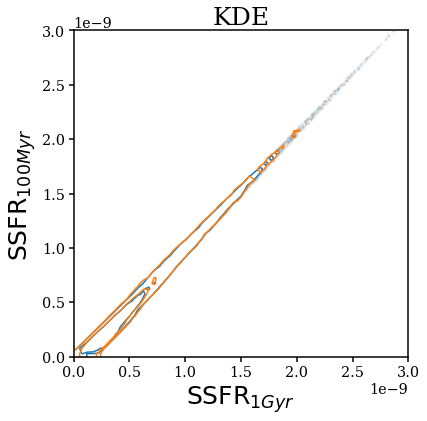

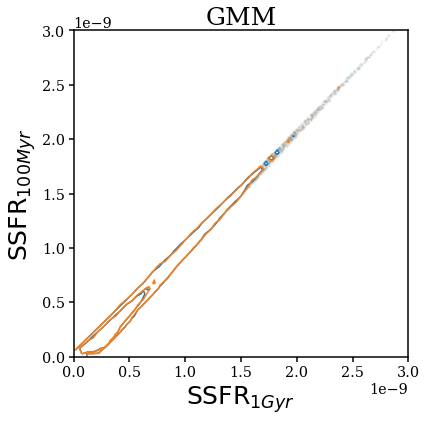

In [10]:
for _samples, name in zip([_kde_samples, _gmm_samples], ['KDE', 'GMM']):
    fig = plt.figure(figsize=(6,6))
    sub = fig.add_subplot(111)

    DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='C0', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60,
            plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
            ax=sub) 

    DFM.hist2d(_samples[0,:], _samples[1,:], color='C1', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60, label=name, 
            plot_datapoints=True, fill_contours=False, plot_density=False, linewidth=0.5, 
            ax=sub) 
    sub.set_title(name, fontsize=25)
    sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
    sub.set_xlim(0, 3e-9)
    sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
    sub.set_ylim(0, 3e-9)

In [11]:
w_kde_ssfr1gyr100myr = 1./kde_ssfr1gyr100myr.pdf(np.array([ssfr_1gyr, ssfr_100myr]) * 1e9)
w_gmm_ssfr1gyr100myr = 1./np.exp(gmm_ssfr1gyr100myr.score_samples(np.array([ssfr_1gyr, ssfr_100myr]).T * 1e9))

(0.0, 3e-09)

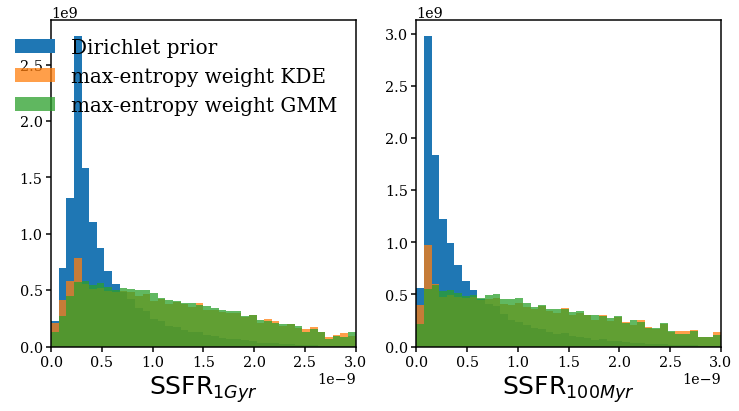

In [12]:
fig = plt.figure(figsize=(12,6))
sub = fig.add_subplot(121)
sub.hist(ssfr_1gyr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight KDE')
sub.hist(ssfr_1gyr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight GMM')

sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

sub = fig.add_subplot(122)
sub.hist(ssfr_100myr, range=[0, 3e-9], bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_100myr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

Lets build a MAF

In [13]:
class Mask_AR(tf.keras.models.Model):
    def __init__(self, *, output_dim, num_masked, n_bijectors=5, hidden_layer=32, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []

        permutation = tf.cast(np.concatenate((np.arange(self.output_dim / 2, self.output_dim), np.arange(0, self.output_dim / 2))),
                      tf.int32)

        # Defining the bijector
        bijectors=[] 
        num_blocks = n_bijectors
        h = hidden_layer

        for i in range(num_blocks): 
            # masked_autoregressive_default_template constructs a special network, 
            # which preserves the autoregressive property, called MADE.
            net = tfb.masked_autoregressive_default_template(hidden_layers=[h, h])
            
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=net))
            
            bijectors.append(tfb.Permute(permutation)) 
            self.nets.append(net) 

        #bijectors.append(tfb.Log())

        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0. for i in range(self.output_dim)]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)

In [14]:
X = tf.convert_to_tensor((np.array([ssfr_1gyr, ssfr_100myr]) * 1e9).T, dtype=tf.float32)

In [15]:
maf = Mask_AR(output_dim=2, num_masked=1, n_bijectors=5, hidden_layer=200)
_ = maf(X)
print(maf.summary())

Instructions for updating:
`masked_autoregressive_default_template` is deprecated; use `tfp.bijectors.AutoregressiveNetwork`.   Also, please note the section "Variable Tracking" in the documentation for `tfp.bijectors.MaskedAutoregressiveFlow`.
Instructions for updating:
Please use `layer.__call__` method instead.
Model: "mask_ar"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 208,020
Trainable params: 208,020
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
maf_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(maf.flow.log_prob(X))


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time()
for i in range(int(1e3+1)):
    loss = train_step(maf, maf_optimizer, X)
    #for batch in batches:
    #    loss = train_step(maf, maf_optimizer, batch)
        
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
0   2.2700844 4.717970371246338
100   -1.121991 116.32464265823364
200   -1.6286262 115.9131531715393
300   -1.7273277 117.11310315132141
400   -1.7434328 117.36600184440613
500   -1.5408229 117.01461887359619
600   -1.6406525 116.71569347381592
700   -1.6991723 115.89392876625061
800   -1.7386355 115.60806584358215
900   -1.7674922 115.5316379070282
1000   -1.7793981 115.61724376678467


In [17]:
Z = np.random.normal(0,1,(10000,2))
_maf_samples = maf(Z).numpy().T * 1e-9


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [18]:
class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, n_bijectors=5, hidden_layer=32, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.nets=[]

        permutation = tf.cast(np.concatenate((np.arange(self.output_dim / 2, self.output_dim), np.arange(0, self.output_dim / 2))),
                      tf.int32)

        # We need to keep track of the nets
        bijectors=[] 
        num_blocks = n_bijectors
        h = hidden_layer
        for i in range(num_blocks): 
            net = tfb.real_nvp_default_template([h, h])
            bijectors.append(
                tfb.RealNVP(shift_and_log_scale_fn=net, 
                            num_masked=num_masked))
            if i % 2 == 0:
              bijectors.append(tfb.BatchNormalization())

            bijectors.append(tfb.Permute(permutation)) 
            self.nets.append(net) 

        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0. for i in range(self.output_dim)]), 
            bijector=bijector)
        
    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)

In [20]:
nvp = RealNVP(output_dim=2, num_masked=1, hidden_layer=200)
_ = nvp(X) 
print(nvp.summary())

Model: "real_nvp_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 205,010
Trainable params: 205,010
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)
nvp_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(nvp.flow.log_prob(X))


@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(model, optimizer, X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

start = time()
for i in range(int(1e3+1)):
    loss = train_step(nvp, nvp_optimizer, X)
    #for batch in batches:
    #    loss = train_step(nvp, nvp_optimizer, batch)
        
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   2.1738782 4.770276784896851
100   -1.7308004 114.45639371871948
200   -1.7851633 114.88885688781738
300   -1.728523 114.5041720867157
400   -1.828676 114.49450254440308
500   -1.8479133 114.27426600456238
600   -1.871459 114.54014325141907
700   -1.8703179 114.63676977157593
800   -1.8830527 114.09388518333435
900   -1.8826524 114.09080219268799
1000   -1.8857802 114.0421130657196


In [22]:
_nvp_samples = nvp(Z).numpy().T * 1e-9


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



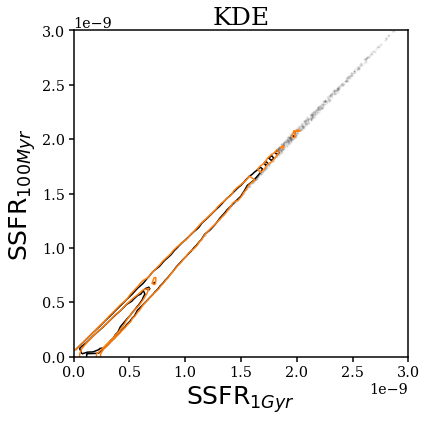

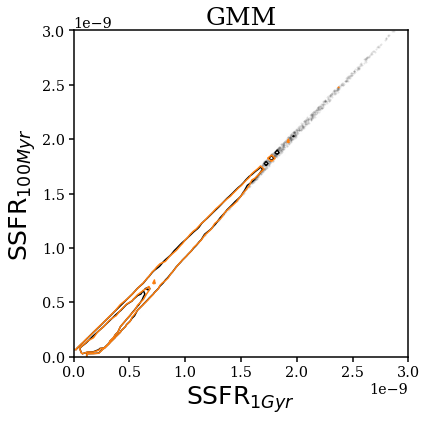

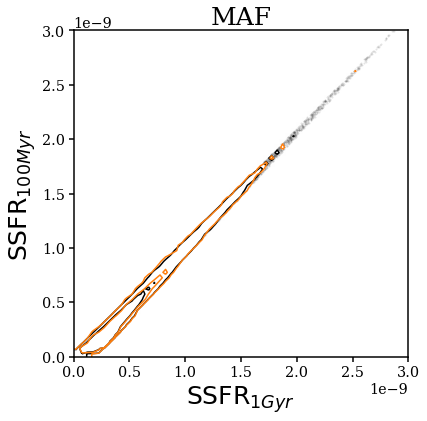

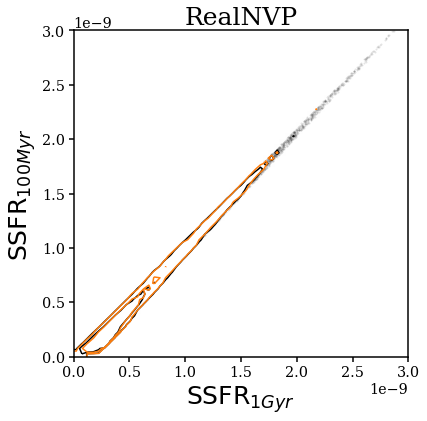

In [23]:
for _samples, name in zip([_kde_samples, _gmm_samples, _maf_samples, _nvp_samples], ['KDE', 'GMM', 'MAF', 'RealNVP']):
    fig = plt.figure(figsize=(6,6))
    sub = fig.add_subplot(111)

    DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='k', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60,
            plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
            ax=sub) 

    DFM.hist2d(_samples[0,:], _samples[1,:], color='C1', levels=[0.68, 0.95], 
            range=[[0., 3e-9], [0., 3e-9]], bins=60, label=name, 
            plot_datapoints=False, fill_contours=False, plot_density=False, linewidth=0.5, 
            ax=sub) 
    sub.set_title(name, fontsize=25)
    sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
    sub.set_xlim(0, 3e-9)
    sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
    sub.set_ylim(0, 3e-9)

In [47]:
ssfr_1gyr.shape

(20000,)

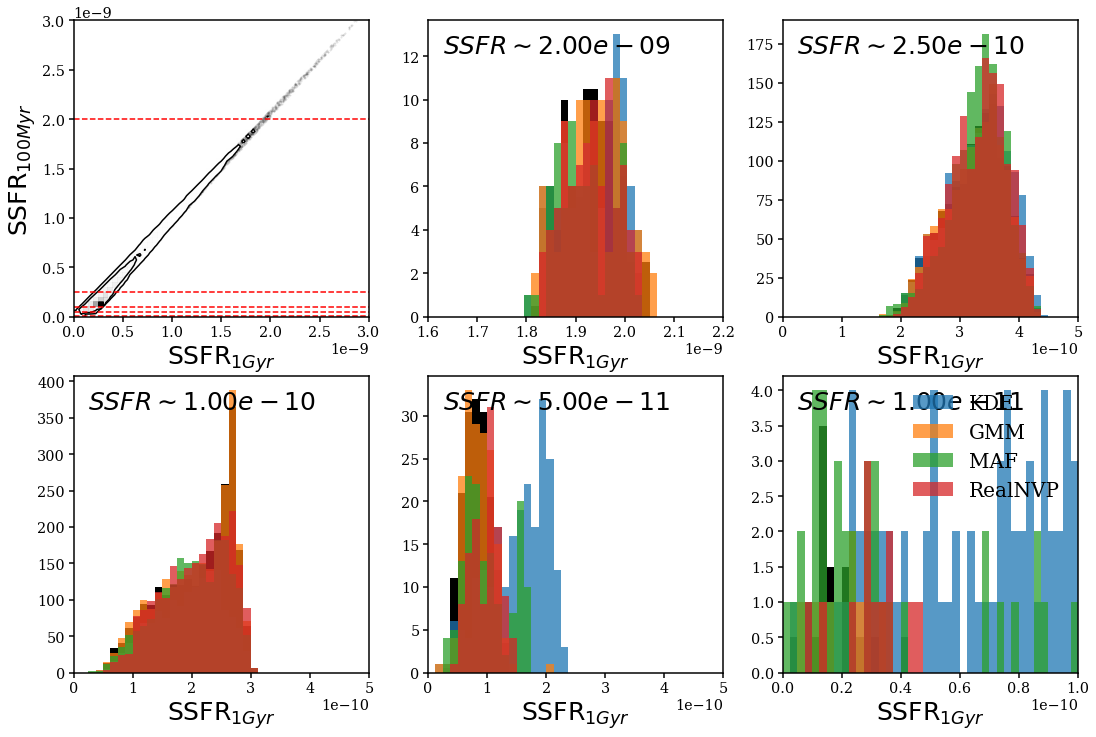

In [51]:
slices = [2e-9, 2.5e-10, 1e-10, 5e-11, 1e-11]
dslices = [1e-10, 5e-11, 5e-11, 1e-11, 1e-11]
ranges = [(1.6e-9, 2.2e-9), (0., 5e-10), (0., 5e-10), (0., 5e-10), (0., 1e-10)]

fig = plt.figure(figsize=(18,12))

sub = fig.add_subplot(231)

DFM.hist2d(ssfr_1gyr, ssfr_100myr, color='k', levels=[0.68, 0.95], 
        range=[[0., 3e-9], [0., 3e-9]], bins=60,  
        plot_datapoints=True, fill_contours=False, plot_density=True, linewidth=0.5, 
        ax=sub) 
for slice in slices: 
  sub.plot([0., 3e-9], [slice, slice], c='r', ls='--')

sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)
sub.set_ylabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_ylim(0, 3e-9)

for i, slice, dslice, _range in zip(range(len(slices)), slices, dslices, ranges): 
  sub = fig.add_subplot(2,3,i+2)
  sub.hist(ssfr_1gyr[(ssfr_100myr > slice - dslice) & (ssfr_100myr < slice + dslice)], color='k', 
           weights=0.5*np.ones(np.sum((ssfr_100myr > slice - dslice) & (ssfr_100myr < slice + dslice))), range=_range, bins=40)#, density=True)

  for _samples, name in zip([_kde_samples, _gmm_samples, _maf_samples, _nvp_samples], ['KDE', 'GMM', 'MAF', 'RealNVP']):
    sub.hist(_samples[0][(_samples[1] > slice - dslice) & (_samples[1] < slice + dslice)], 
             range=_range, alpha=0.75, bins=40, label=name)
  if i == len(slices) - 1: sub.legend(loc='upper right', fontsize=20)
  sub.text(0.05, 0.95, r'$SSFR \sim %.2e$' % slice, 
          transform=sub.transAxes, ha='left', va='top', fontsize=25)
  sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
  sub.set_xlim(_range)

In [38]:
w_maf_ssfr1gyr100myr = 1./maf.flow.prob(X)
w_nvp_ssfr1gyr100myr = 1./nvp.flow.prob(X)

In [37]:
maf.flow.prob

<bound method Distribution.prob of <tfp.distributions.TransformedDistribution 'chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>>

In [43]:
print(ssfr_1gyr[:5])
print(ssfr_100myr[:5])
print((1./w_kde_ssfr1gyr100myr)[:5]/np.sum(1./w_kde_ssfr1gyr100myr))
print((1./w_gmm_ssfr1gyr100myr)[:5]/np.sum(1./w_gmm_ssfr1gyr100myr))
print((1./w_maf_ssfr1gyr100myr.numpy())[:5]/np.sum(1./w_maf_ssfr1gyr100myr))
print((1./w_nvp_ssfr1gyr100myr.numpy())[:5]/np.sum(1./w_nvp_ssfr1gyr100myr))

[2.80975510e-10 4.85717569e-10 5.21719666e-10 1.31950213e-09
 2.63634701e-10]
[1.43611737e-10 4.97593087e-10 4.63052579e-10 1.37205079e-09
 2.45566975e-10]
[1.35690948e-04 2.30347424e-05 3.68870408e-05 1.08617340e-05
 3.94822820e-05]
[1.90182166e-04 1.41584530e-05 1.55973963e-05 7.14643114e-06
 2.02466850e-05]
[7.3701543e-05 2.3649980e-05 8.1269645e-05 1.8531351e-05 2.1091764e-05]
[5.9619433e-05 4.6579462e-05 9.2000824e-05 1.9780404e-05 8.2655752e-06]


(0.0, 3e-09)

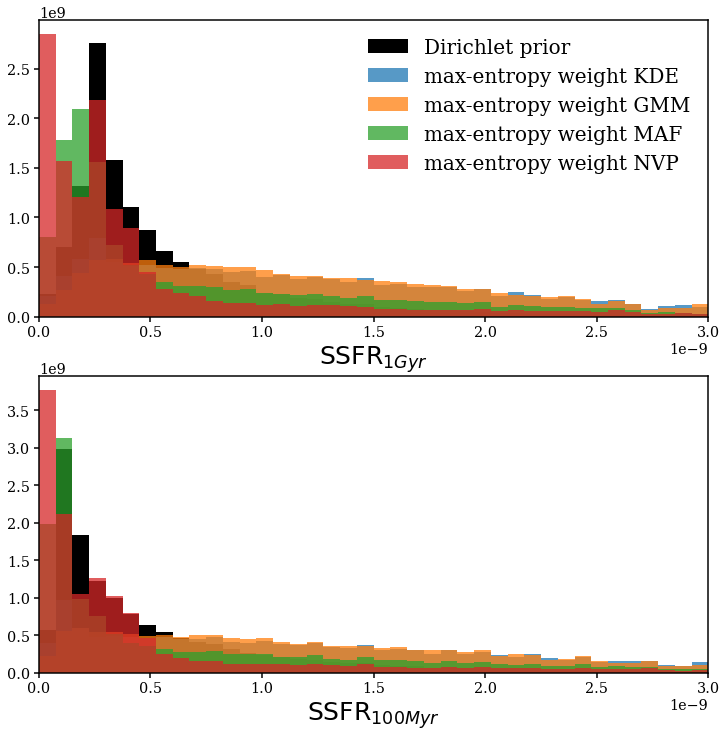

In [33]:
fig = plt.figure(figsize=(12,12))
sub = fig.add_subplot(211)
sub.hist(ssfr_1gyr, range=[0, 3e-9], color='k', bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_1gyr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight KDE')
sub.hist(ssfr_1gyr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight GMM')
sub.hist(ssfr_1gyr, weights=w_maf_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight MAF')
sub.hist(ssfr_1gyr, weights=w_nvp_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight NVP')

sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{1Gyr}$', fontsize=25)
sub.set_xlim(0, 3e-9)

sub = fig.add_subplot(212)
sub.hist(ssfr_100myr, range=[0, 3e-9], color='k', bins=40, density=True, label='Dirichlet prior')
sub.hist(ssfr_100myr, weights=w_kde_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_gmm_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_maf_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight')
sub.hist(ssfr_100myr, weights=w_nvp_ssfr1gyr100myr, range=[0, 3e-9], bins=40, density=True, alpha=0.75, label='max-entropy weight NVP')


#sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel(r'${\rm SSFR}_{100Myr}$', fontsize=25)
sub.set_xlim(0, 3e-9)